In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

warnings.filterwarnings('ignore', category=UserWarning) # Suppress some SHAP/XGBoost warnings
warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None # default='warn', suppress SettingWithCopyWarning for imputation steps

# --- Configuration ---
TARGET_VARIABLE = 'PCT_PRICE_CHANGE_DETRENDED (%)'
RAW_TARGET_VARIABLE = 'PCT_PRICE_CHANGE (%)'
YEAR_COLUMN = 'YEAR'
ZIP_COLUMN = 'GEO_UNIQUE_ID'
TRAIN_YEAR_CUTOFF = 2020
FIRE_EXPOSED_COL = 'FIRE_EXPOSED' # Define the fire exposure column name

# --- XGBoost Tuning Parameters ---
# Define Parameter Grid for XGBoost
XGB_PARAM_GRID = {
    'n_estimators': [100, 200, 300],         # Number of trees
    'learning_rate': [0.05, 0.1, 0.2],       # Step size shrinkage
    'max_depth': [3, 5, 7],                  # Max tree depth
    'subsample': [0.7, 0.8, 0.9],            # Fraction of samples per tree
    'colsample_bytree': [0.7, 0.8, 0.9],     # Fraction of features per tree
    'gamma': [0, 0.1],                       # Minimum loss reduction for split
}
N_CV_SPLITS = 5 # Number of folds for TimeSeriesSplit

# --- Load Data ---
try:
    data = pd.read_csv("../10_Data_Clean/final_data.csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: xgboost_data.csv not found. Please ensure the file is in the correct directory.")
    exit()

Data loaded successfully.


In [29]:
# --- Step 1: Detrending Target Variable ---
print("\n--- Step 1: Detrending Target Variable ---")
if YEAR_COLUMN not in data.columns or RAW_TARGET_VARIABLE not in data.columns:
     raise ValueError(f"Required columns '{YEAR_COLUMN}' or '{RAW_TARGET_VARIABLE}' not found in data.")
data[YEAR_COLUMN] = pd.to_numeric(data[YEAR_COLUMN], errors='coerce')
data = data.dropna(subset=[YEAR_COLUMN, RAW_TARGET_VARIABLE]).copy()

if not data.empty:
    trend_model = LinearRegression()
    trend_model.fit(data[[YEAR_COLUMN]], data[RAW_TARGET_VARIABLE])
    predicted_trend = trend_model.predict(data[[YEAR_COLUMN]])
    data[TARGET_VARIABLE] = data[RAW_TARGET_VARIABLE] - predicted_trend
    print(f"Target variable '{TARGET_VARIABLE}' created.")
    print(f"Target variable mean: {data[TARGET_VARIABLE].mean():.4f}, std: {data[TARGET_VARIABLE].std():.4f}")
else:
    raise ValueError("Data became empty after dropping NaNs in YEAR or RAW_TARGET_VARIABLE.")


--- Step 1: Detrending Target Variable ---
Target variable 'PCT_PRICE_CHANGE_DETRENDED (%)' created.
Target variable mean: 0.0000, std: 10.5283


In [30]:
# --- Step 2: Define Feature Sets & Imputation Rules ---
print("\n--- Step 2: Defining Feature Sets & Imputation Rules ---")

# Core Baseline Features
baseline_features = [
    'Median_Household_Income', 'Total_Population', 'Avg_Household_Size',
    'Gini_Index', 'Employment_Rate', 'Below_Poverty_Rate',
    'Rate_College_or_Higher', 'Black_Portion', 'White_Portion',
    'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion',
    # Lagged Price Features
    'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1', 'PRICE_CHANGE_DIFF',
    'ROLLING_1yr_PRICE_CHANGE', 'ROLLING_2yr_PRICE_CHANGE_STD'
    # Avoid interaction terms involving FIRE here
]

# Specific Wildfire Features (excluding interactions for now)
wildfire_features_only = [
    'NUM_FIRES', 'TOTAL_AREA_BURNED_IN_M2', 'AVG_FIRE_DURATION_DAYS',
    'MAX_PCT_TRACT_BURNED', 'ANY_MAJOR_FIRE', 'FIRE_EXPOSED',
    'PREV_MAX_PCT_TRACT_BURNED', 'FIRE_LAST_YEAR', 'FIRE_SHOCK',
    'YEARS_SINCE_LAST_FIRE', 'CUMULATIVE_AREA_BURNED_LAST_2YRS',
]

# Interaction Terms
interaction_features = [
    'FIRE_EXPOSED_x_PRICE_CHANGE_LAG1',
    'MAX_PCT_TRACT_BURNED_x_ROLLING_1yr_PRICE_CHANGE',
    'FIRE_EXPOSED_x_Median_Household_Income',
    'FIRE_EXPOSED_x_Below_Poverty_Rate'
]

# One-hot encode ‘neighbor_category’
neighbor_dummies = pd.get_dummies(
    data['neighbor_category'],
    prefix='neighbor'
)
data = pd.concat([data, neighbor_dummies], axis=1)

# Add the new columns into your feature list
wildfire_features_only += neighbor_dummies.columns.tolist()

# Filter features to only those present in the data
baseline_features = [f for f in baseline_features if f in data.columns]
wildfire_features_only = [f for f in wildfire_features_only if f in data.columns]
interaction_features = [f for f in interaction_features if f in data.columns]

# --- Define Imputation Rules ---
# 1. Features where NaN means zero activity (primarily fire counts/extent)
zero_fill_fire_metrics = [
    'NUM_FIRES', 'TOTAL_ACRES_BURNED_IN_ZIP', 'AVG_FIRE_DURATION_DAYS',
    'MAX_PCT_ZIP_BURNED', 'ANY_MAJOR_FIRE',
    'PREV_MAX_PCT_ZIP_BURNED', 'FIRE_LAST_YEAR', 'FIRE_SHOCK',
    'CUMULATIVE_ACRES_BURNED_LAST_3YRS',
    # FIRE_EXPOSED is binary, NaN is usually invalid here, but treat as 0 if present
    FIRE_EXPOSED_COL
]
zero_fill_fire_metrics = [f for f in zero_fill_fire_metrics if f in data.columns and f in wildfire_features_only]

# 2. Interaction term definitions (map interaction term to its components)
# Format: {'INTERACTION_TERM': ('FIRE_RELATED_VAR', 'OTHER_VAR')}
interaction_pairs = {
    'FIRE_EXPOSED_x_PRICE_CHANGE_LAG1': (FIRE_EXPOSED_COL, 'PRICE_CHANGE_LAG1'),
    'FIRE_EXPOSED_x_Median_Household_Income': (FIRE_EXPOSED_COL, 'Median_Household_Income'),
    'MAX_PCT_ZIP_BURNED_x_ROLLING_1yr_PRICE_CHANGE': ('MAX_PCT_ZIP_BURNED', 'ROLLING_1yr_PRICE_CHANGE'),
    'FIRE_EXPOSED_x_Below_Poverty_Rate': (FIRE_EXPOSED_COL, 'Below_Poverty_Rate')
}
# Filter pairs to only those where term and components exist in the data
interaction_pairs = {
    k: v for k, v in interaction_pairs.items()
    if k in interaction_features and v[0] in data.columns and v[1] in data.columns
}

# 3. Features for Grouped Median Imputation (based on FIRE_EXPOSED status)
grouped_median_impute_cols = [
    'Median_Household_Income', 'Employment_Rate',
    'ROLLING_1yr_PRICE_CHANGE', 'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1', 'PRICE_CHANGE_DIFF',
    'YEARS_SINCE_LAST_FIRE', 'Below_Poverty_Rate'
]
grouped_median_impute_cols = [f for f in grouped_median_impute_cols if f in data.columns]
grouped_median_impute_cols = list(set(grouped_median_impute_cols) - set(zero_fill_fire_metrics)) # Avoid double handling

# --- Combine Feature Sets ---
# Baseline model uses only baseline features
# Wildfire model uses baseline + wildfire-only + interactions
all_features = sorted(list(set(baseline_features + wildfire_features_only + interaction_features)))

# Ensure FIRE_EXPOSED_COL is in the feature lists if needed for imputation/modeling
if FIRE_EXPOSED_COL not in baseline_features:
    print(f"Note: '{FIRE_EXPOSED_COL}' not in baseline_features list, will be added temporarily if needed for grouped imputation.")
if FIRE_EXPOSED_COL not in all_features and FIRE_EXPOSED_COL in data.columns:
    all_features.append(FIRE_EXPOSED_COL)
    all_features = sorted(list(set(all_features)))

# Verify no target/future leakage
leaky_features = ['PRICE', 'NEXT_YEAR_PRICE', 'PRICE_CHANGE', RAW_TARGET_VARIABLE, TARGET_VARIABLE]
for f in leaky_features:
    if f in all_features:
        print(f"CRITICAL WARNING: Leaky feature '{f}' found in 'all_features'. Removing.")
        all_features.remove(f)
    if f in baseline_features:
        print(f"CRITICAL WARNING: Leaky feature '{f}' found in 'baseline_features'. Removing.")
        baseline_features.remove(f)

print(f"\nUsing Baseline Features ({len(baseline_features)}): {baseline_features}")
print(f"Using Wildfire Features Only ({len(wildfire_features_only)}): {wildfire_features_only}")
print(f"Using Interaction Features ({len(interaction_features)}): {interaction_features}")
print(f"Using All Features for WF model ({len(all_features)}): {all_features}")
print(f"\nImputation Rules:")
print(f" Zero-fill NaNs for ({len(zero_fill_fire_metrics)}): {zero_fill_fire_metrics}")
print(f" Grouped median impute for ({len(grouped_median_impute_cols)}): {grouped_median_impute_cols}")
print(f" Interaction handling for ({len(interaction_pairs)}): {list(interaction_pairs.keys())}")


--- Step 2: Defining Feature Sets & Imputation Rules ---
Note: 'FIRE_EXPOSED' not in baseline_features list, will be added temporarily if needed for grouped imputation.

Using Baseline Features (16): ['Median_Household_Income', 'Total_Population', 'Avg_Household_Size', 'Gini_Index', 'Employment_Rate', 'Below_Poverty_Rate', 'Rate_College_or_Higher', 'Black_Portion', 'White_Portion', 'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion', 'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1', 'PRICE_CHANGE_DIFF', 'ROLLING_1yr_PRICE_CHANGE', 'ROLLING_2yr_PRICE_CHANGE_STD']
Using Wildfire Features Only (15): ['NUM_FIRES', 'TOTAL_AREA_BURNED_IN_M2', 'AVG_FIRE_DURATION_DAYS', 'MAX_PCT_TRACT_BURNED', 'ANY_MAJOR_FIRE', 'FIRE_EXPOSED', 'PREV_MAX_PCT_TRACT_BURNED', 'FIRE_LAST_YEAR', 'FIRE_SHOCK', 'YEARS_SINCE_LAST_FIRE', 'CUMULATIVE_AREA_BURNED_LAST_2YRS', 'neighbor_affected', 'neighbor_close_neighbor', 'neighbor_far_neighbor', 'neighbor_very_close_neighbor']
Using Interaction Features (4): ['FIRE_EXPOS

In [31]:
# --- Step 3: Sort Data and Temporal Split ---
print(f"\n--- Step 3: Splitting Data: Train <= {TRAIN_YEAR_CUTOFF}, Test > {TRAIN_YEAR_CUTOFF} ---")
data = data.sort_values(by=[YEAR_COLUMN, ZIP_COLUMN]).reset_index(drop=True)

train_data = data[data[YEAR_COLUMN] <= TRAIN_YEAR_CUTOFF].copy()
test_data = data[data[YEAR_COLUMN] > TRAIN_YEAR_CUTOFF].copy()

if train_data.empty or test_data.empty:
    raise ValueError(f"Train or test split resulted in empty DataFrame. Check TRAIN_YEAR_CUTOFF ({TRAIN_YEAR_CUTOFF}).")
if not train_data.empty and not test_data.empty and train_data[YEAR_COLUMN].max() >= test_data[YEAR_COLUMN].min():
     print(f"Warning: Potential overlap/edge case in year split. Max train year: {train_data[YEAR_COLUMN].max()}, Min test year: {test_data[YEAR_COLUMN].min()}")

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape:  {test_data.shape}")

y_train = train_data[TARGET_VARIABLE]
y_test = test_data[TARGET_VARIABLE]

# Get Raw Feature Sets for Preprocessing
X_train_base_raw = train_data[baseline_features].copy()
X_test_base_raw = test_data[baseline_features].copy()

X_train_wf_raw = train_data[all_features].copy()
X_test_wf_raw = test_data[all_features].copy()

# --- Add FIRE_EXPOSED_COL temporarily if needed for grouped imputation ---
# For baseline features
if FIRE_EXPOSED_COL not in X_train_base_raw.columns and FIRE_EXPOSED_COL in train_data.columns:
    X_train_base_raw[FIRE_EXPOSED_COL] = train_data[FIRE_EXPOSED_COL]
    X_test_base_raw[FIRE_EXPOSED_COL] = test_data[FIRE_EXPOSED_COL]
    print(f"Temporarily added '{FIRE_EXPOSED_COL}' to baseline features for imputation.")
# For wildfire features (should already be there if defined correctly)
if FIRE_EXPOSED_COL not in X_train_wf_raw.columns and FIRE_EXPOSED_COL in train_data.columns:
     X_train_wf_raw[FIRE_EXPOSED_COL] = train_data[FIRE_EXPOSED_COL]
     X_test_wf_raw[FIRE_EXPOSED_COL] = test_data[FIRE_EXPOSED_COL]
     print(f"Added '{FIRE_EXPOSED_COL}' to wildfire features (was missing).")


--- Step 3: Splitting Data: Train <= 2020, Test > 2020 ---
Train data shape: (60185, 44)
Test data shape:  (13238, 44)
Temporarily added 'FIRE_EXPOSED' to baseline features for imputation.


In [32]:
# --- Step 4: Preprocessing Pipeline (Grouped Impute THEN Scale) ---
print("\n--- Step 4: Preprocessing Pipeline (Grouped Impute THEN Scale) ---")

def preprocess_features_grouped_impute(X_train, X_test,
                                      fire_exposed_col='FIRE_EXPOSED',
                                      zero_fill_metrics=None,
                                      grouped_median_cols=None,
                                      interaction_pairs_dict=None):
    """
    Applies grouped imputation based on FIRE_EXPOSED status, then scales.
    Fits imputation stats and scaler ONLY on training data.
    """
    print(f"--- Preprocessing {len(X_train.columns)} features ---")
    X_train_proc = X_train.copy()
    X_test_proc = X_test.copy()
    feature_names = X_train.columns.tolist()
    imputation_values_train = {}

    if fire_exposed_col not in X_train.columns or fire_exposed_col not in X_test.columns:
         raise ValueError(f"'{fire_exposed_col}' column missing from input DataFrames for preprocessing.")

    # --- Imputation Strategy ---

    # 1. Handle explicit zero-fill metrics first
    if zero_fill_metrics:
        actual_zero_fill = [col for col in zero_fill_metrics if col in feature_names]
        if actual_zero_fill:
            print(f" 1. Zero-filling NaNs for: {actual_zero_fill}")
            for col in actual_zero_fill:
                X_train_proc[col] = X_train_proc[col].fillna(0)
                X_test_proc[col] = X_test_proc[col].fillna(0)
        else:
            print(" 1. No specified zero-fill metrics found in columns.")

    # 2. Handle Interaction Terms
    if interaction_pairs_dict:
        print(" 2. Handling interaction terms...")
        for interaction_term, components in interaction_pairs_dict.items():
            if interaction_term not in feature_names: continue

            fire_comp, _ = components # ('FIRE_RELATED_VAR', 'OTHER_VAR')

            # Need fire component values (use 0 if NaN after potential zero-fill)
            fire_component_values_train = X_train_proc[fire_comp].fillna(0)
            fire_component_values_test = X_test_proc[fire_comp].fillna(0)

            # Condition where interaction should be 0 (fire component is 0)
            zero_condition_train = (fire_component_values_train == 0)
            zero_condition_test = (fire_component_values_test == 0)

            # Impute with 0 where condition is met AND interaction term is NaN
            train_null_mask = X_train_proc[interaction_term].isnull()
            test_null_mask = X_test_proc[interaction_term].isnull()
            X_train_proc.loc[zero_condition_train & train_null_mask, interaction_term] = 0
            X_test_proc.loc[zero_condition_test & test_null_mask, interaction_term] = 0

            # For remaining NaNs (where fire comp > 0), use grouped median from TRAIN
            if X_train_proc.loc[~zero_condition_train, interaction_term].isnull().any():
                 median_interaction_fire = X_train_proc.loc[~zero_condition_train, interaction_term].median()
                 imputation_values_train[interaction_term + '_fire'] = median_interaction_fire

                 # Apply to remaining NaNs in both train and test
                 X_train_proc.loc[~zero_condition_train & X_train_proc[interaction_term].isnull(), interaction_term] = median_interaction_fire
                 X_test_proc.loc[~zero_condition_test & X_test_proc[interaction_term].isnull(), interaction_term] = median_interaction_fire
            else:
                 # Store NaN or 0 if no valid median could be calculated (e.g., all NaNs or no fire>0 cases)
                 imputation_values_train[interaction_term + '_fire'] = X_train_proc.loc[~zero_condition_train, interaction_term].median() # Recalc to store NaN if needed
                 # Apply this value (could be NaN) - will be handled by fallback imputer if necessary
                 X_test_proc.loc[~zero_condition_test & X_test_proc[interaction_term].isnull(), interaction_term] = imputation_values_train[interaction_term + '_fire']


    # 3. Grouped Median Imputation for other columns
    if grouped_median_cols:
        print(f" 3. Applying grouped median imputation for: {grouped_median_cols}")
        # Get indices for fire/no-fire groups IN TRAINING DATA
        train_fire_idx = X_train_proc[fire_exposed_col] == 1
        train_no_fire_idx = X_train_proc[fire_exposed_col] == 0
        # Get indices for TEST data groups
        test_fire_idx = X_test_proc[fire_exposed_col] == 1
        test_no_fire_idx = X_test_proc[fire_exposed_col] == 0

        for col in grouped_median_cols:
            if col not in feature_names: continue
            if X_train_proc[col].isnull().any() or X_test_proc[col].isnull().any(): # Check if imputation needed
                # Calculate medians ONLY from Training data groups
                median_no_fire = X_train_proc.loc[train_no_fire_idx, col].median()
                median_fire = X_train_proc.loc[train_fire_idx, col].median()

                # Store medians
                imputation_values_train[col + '_no_fire'] = median_no_fire
                imputation_values_train[col + '_fire'] = median_fire

                # Apply to TRAIN set
                X_train_proc.loc[train_no_fire_idx, col] = X_train_proc.loc[train_no_fire_idx, col].fillna(median_no_fire)
                X_train_proc.loc[train_fire_idx, col] = X_train_proc.loc[train_fire_idx, col].fillna(median_fire)

                # Apply to TEST set (using medians learned from TRAIN)
                X_test_proc.loc[test_no_fire_idx, col] = X_test_proc.loc[test_no_fire_idx, col].fillna(median_no_fire)
                X_test_proc.loc[test_fire_idx, col] = X_test_proc.loc[test_fire_idx, col].fillna(median_fire)

    # 4. Final check for any remaining NaNs (use global median as fallback)
    fallback_imputer = SimpleImputer(strategy='median')
    try:
        # Check NaNs *after* all specific imputations
        if X_train_proc.isnull().values.any():
            nan_cols_train = X_train_proc.columns[X_train_proc.isnull().any()].tolist()
            print(f" 4. WARNING: NaNs still present after specific imputations in TRAIN columns: {nan_cols_train}. Applying global median fallback...")
            X_train_proc[nan_cols_train] = fallback_imputer.fit_transform(X_train_proc[nan_cols_train])
            # Check and apply to test set for same columns if needed
            nan_cols_test = X_test_proc.columns[X_test_proc.isnull().any()].tolist()
            cols_to_transform_test = [col for col in nan_cols_train if col in nan_cols_test]
            if cols_to_transform_test:
                 print(f"    Applying fallback imputation to TEST columns: {cols_to_transform_test}")
                 X_test_proc[cols_to_transform_test] = fallback_imputer.transform(X_test_proc[cols_to_transform_test])
        else:
             print(" 4. No NaNs found after specific imputations. Skipping fallback.")
             # Fit the imputer anyway in case test set has NaNs in columns train didn't
             fallback_imputer.fit(X_train_proc)


        # Final check on TEST set for any NaNs missed (e.g., column had no NaNs in train but does in test)
        if X_test_proc.isnull().values.any():
             nan_cols_test_final = X_test_proc.columns[X_test_proc.isnull().any()].tolist()
             print(f"    WARNING: NaNs found in TEST columns: {nan_cols_test_final} possibly missed by train fit. Applying fallback transform...")
             # Use the imputer fitted on train data
             X_test_proc[nan_cols_test_final] = fallback_imputer.transform(X_test_proc[nan_cols_test_final])


    except ValueError as e:
         print(f"ERROR during fallback imputation: {e}. NaNs might remain.")


    # --- Scaling Step ---
    print(" 5. Applying StandardScaler...")
    scaler = StandardScaler()
    # Ensure column order is the same before scaling
    X_train_proc = X_train_proc[feature_names]
    X_test_proc = X_test_proc[feature_names]

    X_train_scaled = scaler.fit_transform(X_train_proc)
    X_test_scaled = scaler.transform(X_test_proc)

    # Convert back to DataFrame
    X_train_processed = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
    X_test_processed = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)

    print("--- Preprocessing Complete ---")
    return X_train_processed, X_test_processed, scaler, imputation_values_train # Return learned values


# --- Apply Preprocessing ---

print("\nProcessing Baseline Features (Grouped Impute THEN Scale)...")
X_train_base_processed, X_test_base_processed, scaler_base, impute_vals_base = preprocess_features_grouped_impute(
    X_train_base_raw, X_test_base_raw,
    fire_exposed_col=FIRE_EXPOSED_COL,
    zero_fill_metrics=[], # No specific fire metrics in baseline usually
    grouped_median_cols= [c for c in grouped_median_impute_cols if c in baseline_features], # Only impute baseline cols
    interaction_pairs_dict={} # No interactions in baseline
)
print("Baseline features processed.")

# Remove the temporarily added FIRE_EXPOSED_COL from baseline processed sets if it wasn't originally intended
if FIRE_EXPOSED_COL in X_train_base_processed.columns and FIRE_EXPOSED_COL not in baseline_features:
    X_train_base_processed = X_train_base_processed.drop(columns=[FIRE_EXPOSED_COL])
    X_test_base_processed = X_test_base_processed.drop(columns=[FIRE_EXPOSED_COL])
    print(f"Removed temporary '{FIRE_EXPOSED_COL}' from processed baseline features.")


print("\nProcessing All Features (Wildfire Included - Grouped Impute THEN Scale)...")
X_train_wf_processed, X_test_wf_processed, scaler_wf, impute_vals_wf = preprocess_features_grouped_impute(
    X_train_wf_raw, X_test_wf_raw,
    fire_exposed_col=FIRE_EXPOSED_COL,
    zero_fill_metrics=zero_fill_fire_metrics,
    grouped_median_cols=grouped_median_impute_cols,
    interaction_pairs_dict=interaction_pairs
)
print("All features (including wildfire) processed.")


--- Step 4: Preprocessing Pipeline (Grouped Impute THEN Scale) ---

Processing Baseline Features (Grouped Impute THEN Scale)...
--- Preprocessing 17 features ---
 3. Applying grouped median imputation for: ['Median_Household_Income', 'ROLLING_1yr_PRICE_CHANGE', 'Employment_Rate', 'HOME_PRICE_LAG1', 'PRICE_CHANGE_DIFF', 'Below_Poverty_Rate', 'PRICE_CHANGE_LAG1']
 4. No NaNs found after specific imputations. Skipping fallback.
 5. Applying StandardScaler...
--- Preprocessing Complete ---
Baseline features processed.
Removed temporary 'FIRE_EXPOSED' from processed baseline features.

Processing All Features (Wildfire Included - Grouped Impute THEN Scale)...
--- Preprocessing 35 features ---
 1. Zero-filling NaNs for: ['NUM_FIRES', 'AVG_FIRE_DURATION_DAYS', 'ANY_MAJOR_FIRE', 'FIRE_LAST_YEAR', 'FIRE_SHOCK', 'FIRE_EXPOSED']
 2. Handling interaction terms...
 3. Applying grouped median imputation for: ['Median_Household_Income', 'ROLLING_1yr_PRICE_CHANGE', 'Employment_Rate', 'YEARS_SINCE_LAS

/opt/miniconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [33]:
# --- Step 4.5: Train Benchmark Linear Regression Models ---
print("\n--- Step 4.5: Training Benchmark Linear Regression Models ---")

# --- Train Linear Regression (Baseline Features) ---
print("Training Linear Regression (Baseline - Grouped Imputed)...")
lr_base = LinearRegression(n_jobs=-1) # Use n_jobs=-1 for potential parallelization if applicable
# Ensure processed data is used and has no NaNs
if X_train_base_processed.isnull().values.any():
    raise ValueError("NaNs detected in X_train_base_processed before LR training!")
lr_base.fit(X_train_base_processed, y_train)
print("Linear Regression (Baseline) trained.")

# --- Train Linear Regression (Wildfire Features) ---
print("Training Linear Regression (Wildfire - Grouped Imputed)...")
lr_wf = LinearRegression(n_jobs=-1)
# Ensure processed data is used and has no NaNs
if X_train_wf_processed.isnull().values.any():
    raise ValueError("NaNs detected in X_train_wf_processed before LR training!")
lr_wf.fit(X_train_wf_processed, y_train)
print("Linear Regression (Wildfire) trained.")


--- Step 4.5: Training Benchmark Linear Regression Models ---
Training Linear Regression (Baseline - Grouped Imputed)...
Linear Regression (Baseline) trained.
Training Linear Regression (Wildfire - Grouped Imputed)...
Linear Regression (Wildfire) trained.


In [34]:
# --- Step 5: Cross-Validation and Hyperparameter Tuning ---
print("\n--- Step 5: Cross-Validation and Hyperparameter Tuning ---")

# Define Temporal Cross-Validation Strategy
tscv = TimeSeriesSplit(n_splits=N_CV_SPLITS)

# --- Tuning Function ---
def tune_xgboost(X_train, y_train, param_grid, cv_strategy):
    """Performs GridSearchCV for XGBoost."""
    xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
    search = GridSearchCV(xgb, param_grid=param_grid,
                          scoring='neg_root_mean_squared_error', # Optimize for lower RMSE
                          n_jobs=-1, cv=cv_strategy, verbose=1)
    try:
        search.fit(X_train, y_train)
        print(f"Best parameters found: {search.best_params_}")
        print(f"Best CV score (neg_RMSE): {search.best_score_:.4f}")
        return search.best_estimator_, search.best_params_
    except ValueError as e:
        print(f"ERROR during GridSearchCV: {e}")
        print("Tuning failed, returning default XGBoost model.")
        # Fallback to default model if tuning fails
        default_xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
        default_xgb.fit(X_train, y_train)
        return default_xgb, {} # Return default model and empty params

# --- Tune Baseline Model ---
print("\nTuning XGBoost (Baseline - Grouped Imputed)...")
# Ensure processed data is used and has no NaNs
if X_train_base_processed.isnull().values.any():
    raise ValueError("NaNs detected in X_train_base_processed before tuning!")
best_xgb_base, best_params_base = tune_xgboost(X_train_base_processed, y_train, XGB_PARAM_GRID, tscv)

# --- Tune Wildfire Model ---
print("\nTuning XGBoost (Wildfire - Grouped Imputed)...")
if X_train_wf_processed.isnull().values.any():
    raise ValueError("NaNs detected in X_train_wf_processed before tuning!")
best_xgb_wf, best_params_wf = tune_xgboost(X_train_wf_processed, y_train, XGB_PARAM_GRID, tscv)


--- Step 5: Cross-Validation and Hyperparameter Tuning ---

Tuning XGBoost (Baseline - Grouped Imputed)...
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best parameters found: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}
Best CV score (neg_RMSE): -4.4918

Tuning XGBoost (Wildfire - Grouped Imputed)...
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}
Best CV score (neg_RMSE): -4.5284


In [35]:
# --- Step 6: Evaluation on Test Set with Tuned and Benchmark Models ---
print("\n--- Step 6: Evaluating Tuned XGBoost and Benchmark LR Models on Test Set ---")

results = {}
predictions = {}

models_to_evaluate = {
    # Benchmark Linear Regression Models
    "Linear Regression (Baseline GI)": (lr_base, X_test_base_processed),
    "Linear Regression (Wildfire GI)": (lr_wf, X_test_wf_processed),

    # Tuned XGBoost Models
    f"XGBoost (Baseline - Tuned GI)": (best_xgb_base, X_test_base_processed),
    f"XGBoost (Wildfire - Tuned GI)": (best_xgb_wf, X_test_wf_processed)
}

for name, (model, X_test_data) in models_to_evaluate.items():
    if X_test_data.isnull().values.any():
         print(f"CRITICAL WARNING: NaNs detected in FINAL test data for {name} before prediction. Check preprocessing logic.")

    y_pred = model.predict(X_test_data)
    predictions[name] = y_pred
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    print(f"\n--- {name} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R2:   {r2:.4f}")


--- Step 6: Evaluating Tuned XGBoost and Benchmark LR Models on Test Set ---

--- Linear Regression (Baseline GI) ---
RMSE: 6.4932
MAE:  4.7516
R2:   0.5975

--- Linear Regression (Wildfire GI) ---
RMSE: 6.4794
MAE:  4.7277
R2:   0.5992

--- XGBoost (Baseline - Tuned GI) ---
RMSE: 3.7837
MAE:  2.9044
R2:   0.8633

--- XGBoost (Wildfire - Tuned GI) ---
RMSE: 3.2900
MAE:  2.5543
R2:   0.8967


In [36]:
# --- Step 7: Compare Results Summary ---
print("\n--- Step 7: Comparison Summary (Tuned Models, Grouped Imputed - Test Set Performance) ---")
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='R2', ascending=False))

# --- R2 Improvement Check ---
print("\n--- R2 Improvement from Wildfire Features (Tuned Models, Grouped Imputed) ---")
base_name = f"XGBoost (Baseline - Tuned GI)"
wf_name = f"XGBoost (Wildfire - Tuned GI)"
if base_name in results and wf_name in results:
    base_r2 = results[base_name]["R2"]
    wf_r2 = results[wf_name]["R2"]
    improvement = wf_r2 - base_r2
    print(f"Baseline R2: {base_r2:.4f}")
    print(f"Wildfire R2: {wf_r2:.4f}")
    print(f"Improvement: {improvement:.4f} ({'IMPROVED' if improvement > 0 else ('WORSENED' if improvement < 0 else 'NO CHANGE')})")
else:
    print("Could not compare tuned XGBoost models (Grouped Imputed), results missing.")

print("\n--- R2 Improvement from Wildfire Features (Linear Regression Models, Grouped Imputed) ---")
base_name_lr = "Linear Regression (Baseline GI)"
wf_name_lr = "Linear Regression (Wildfire GI)"
if base_name_lr in results and wf_name_lr in results:
    base_r2_lr = results[base_name_lr]["R2"]
    wf_r2_lr = results[wf_name_lr]["R2"]
    improvement_lr = wf_r2_lr - base_r2_lr
    print(f"(LR) Baseline R2: {base_r2_lr:.4f}")
    print(f"(LR) Wildfire R2: {wf_r2_lr:.4f}")
    print(f"(LR) Improvement: {improvement_lr:.4f} ({'IMPROVED' if improvement_lr > 0 else ('WORSENED' if improvement_lr < 0 else 'NO CHANGE')})")
else:
    print("Could not compare Linear Regression models, results missing.")



--- Step 7: Comparison Summary (Tuned Models, Grouped Imputed - Test Set Performance) ---
                                     RMSE       MAE        R2
XGBoost (Wildfire - Tuned GI)    3.290022  2.554342  0.896653
XGBoost (Baseline - Tuned GI)    3.783685  2.904368  0.863312
Linear Regression (Wildfire GI)  6.479430  4.727705  0.599158
Linear Regression (Baseline GI)  6.493171  4.751575  0.597456

--- R2 Improvement from Wildfire Features (Tuned Models, Grouped Imputed) ---
Baseline R2: 0.8633
Wildfire R2: 0.8967
Improvement: 0.0333 (IMPROVED)

--- R2 Improvement from Wildfire Features (Linear Regression Models, Grouped Imputed) ---
(LR) Baseline R2: 0.5975
(LR) Wildfire R2: 0.5992
(LR) Improvement: 0.0017 (IMPROVED)



--- Step 8: Extracting Wildfire Effect using SHAP ---
Initializing SHAP TreeExplainer...
Calculating SHAP values for the test set (might take time)...

1. SHAP Global Feature Importance (Test Set):


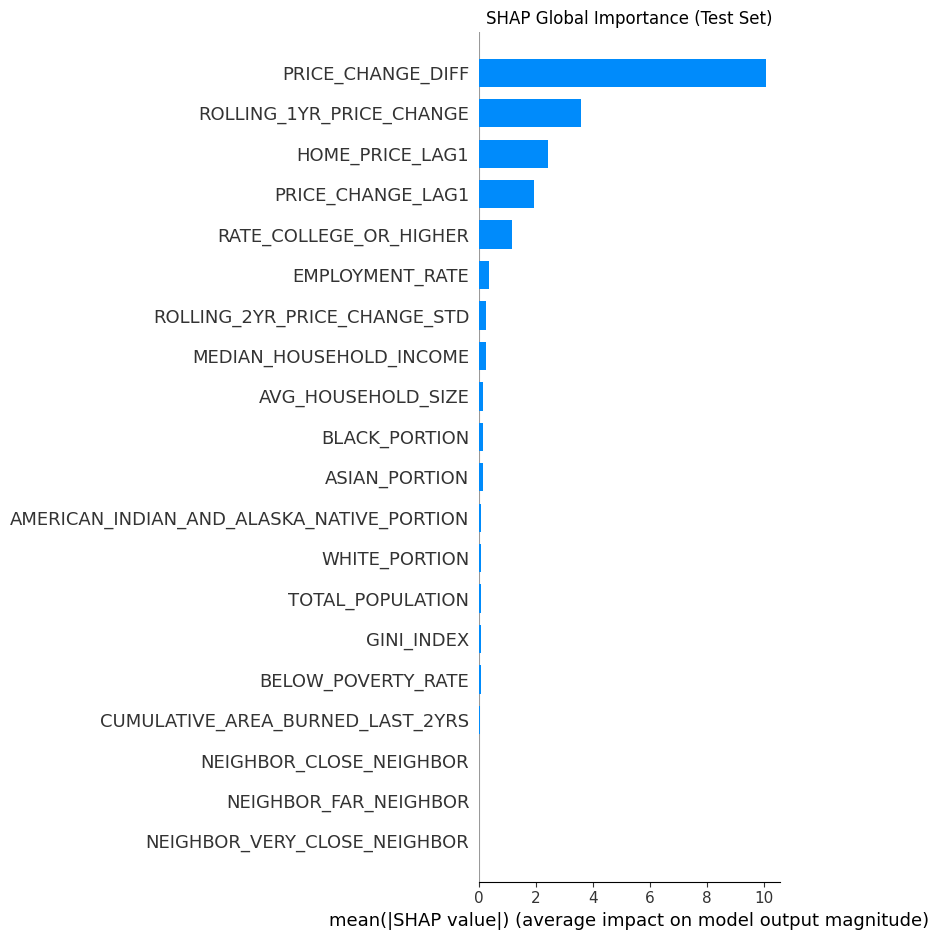


2. SHAP Summary Plot (Beeswarm - Test Set):


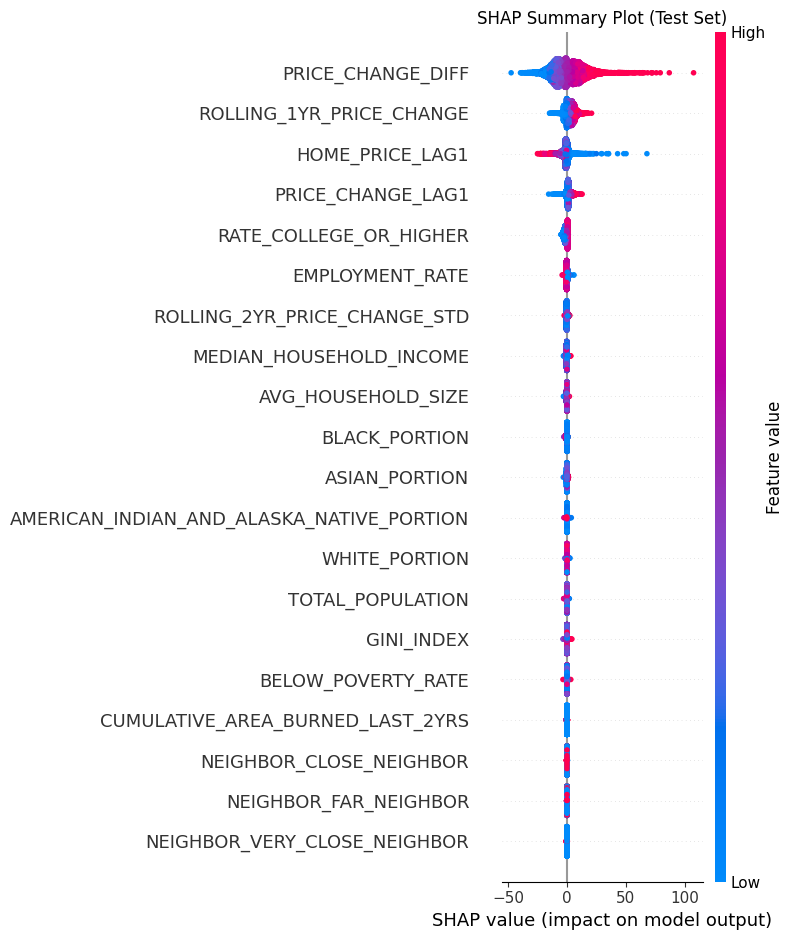


3. SHAP Dependence Plots for Key Wildfire Features (Test Set):


<Figure size 640x480 with 0 Axes>

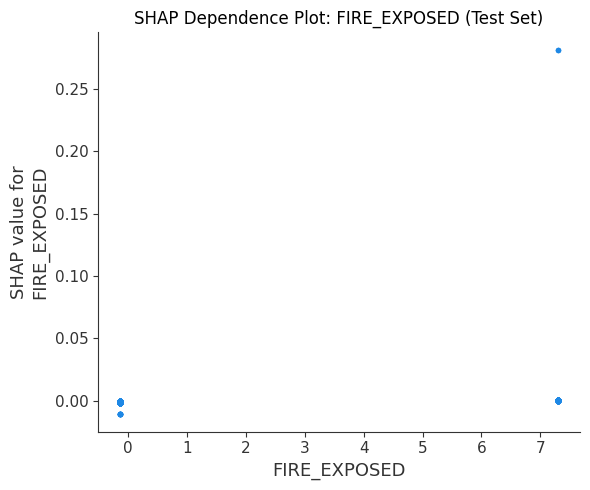

<Figure size 640x480 with 0 Axes>

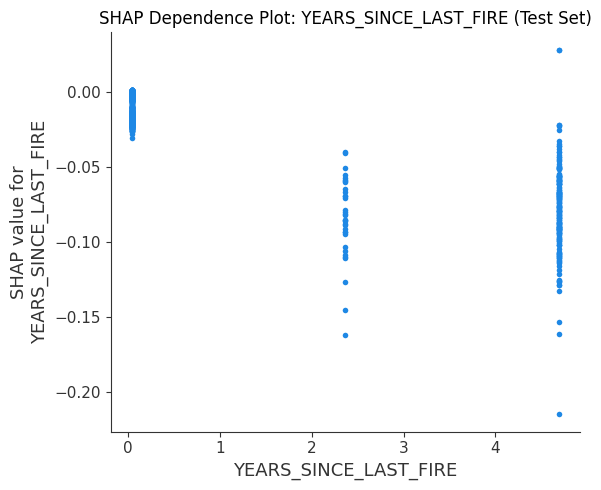

<Figure size 640x480 with 0 Axes>

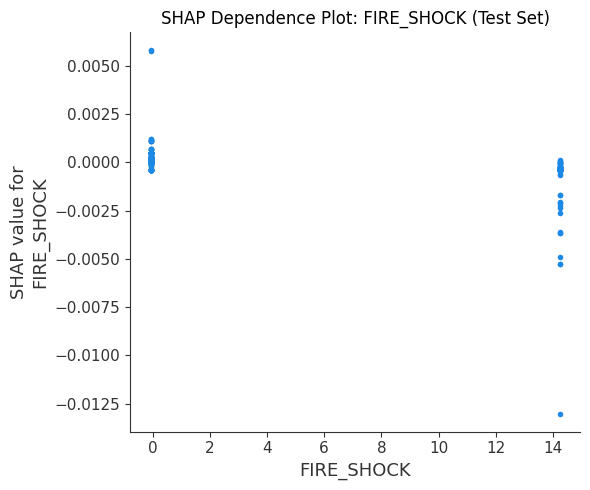

<Figure size 640x480 with 0 Axes>

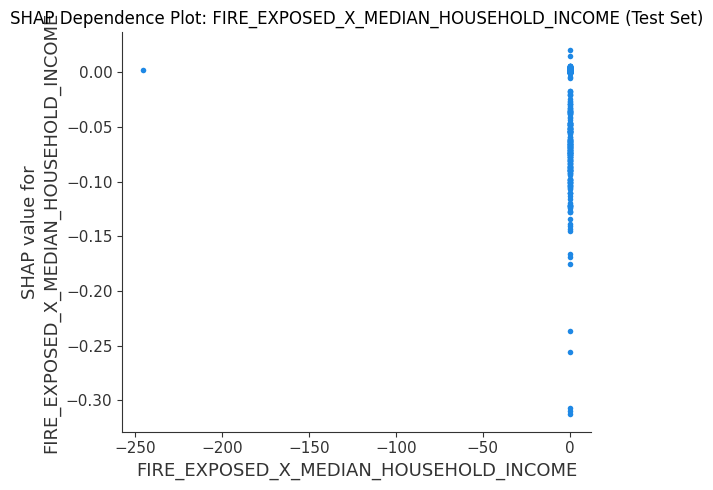


4. Comparing Predictions: Wildfire Model vs Baseline Model (Test Set)


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

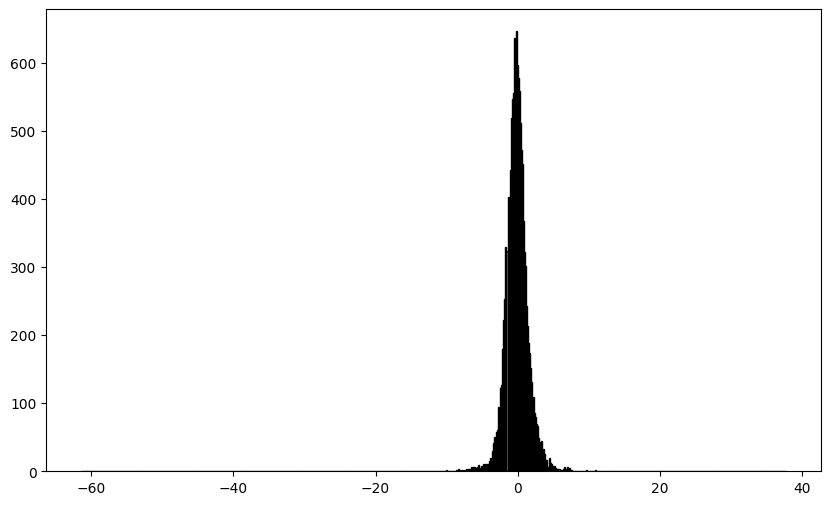

In [ ]:
# --- Step 8: Rigorous Extraction of Wildfire Effect using SHAP ---
print("\n--- Step 8: Extracting Wildfire Effect using SHAP ---")

model_for_shap = best_xgb_wf
# Explain using the final processed training data (Grouped Imputed then Scaled)
X_shap_train = X_train_wf_processed
X_shap_test = X_test_wf_processed
X_shap_train = X_shap_train.rename(columns=str.upper)
X_shap_test  = X_shap_test.rename(columns=str.upper)

print("Initializing SHAP TreeExplainer...")
explainer = shap.TreeExplainer(model_for_shap)

# Calculate SHAP values
print("Calculating SHAP values for the test set (might take time)...")
# Check for NaNs before SHAP calculation
if X_shap_test.isnull().values.any():
        raise ValueError("NaNs found in data provided to SHAP explainer. Check preprocessing.")
shap_values_test = explainer.shap_values(X_shap_test)


# --- SHAP Plots using Test Set Explanations ---

print("\n1. SHAP Global Feature Importance (Test Set):")
plt.figure(figsize=(10, max(8, len(X_shap_test.columns) * 0.3)))
shap.summary_plot(shap_values_test, X_shap_test, plot_type="bar", show=False)
plt.title("SHAP Global Importance (Test Set)")
plt.tight_layout()
plt.show()

print("\n2. SHAP Summary Plot (Beeswarm - Test Set):")
plt.figure(figsize=(10, max(8, len(X_shap_test.columns) * 0.3)))
shap.summary_plot(shap_values_test, X_shap_test, show=False)
plt.title("SHAP Summary Plot (Test Set)")
plt.tight_layout()
plt.show()

print("\n3. SHAP Dependence Plots for Key Wildfire Features (Test Set):")
# Select key features relevant to wildfire impact
key_wf_features_for_plot = [
    'MAX_PCT_ZIP_BURNED', 'TOTAL_ACRES_BURNED_IN_ZIP', FIRE_EXPOSED_COL,
    'YEARS_SINCE_LAST_FIRE', 'FIRE_SHOCK',
    # Include important interaction terms if they exist
    'MAX_PCT_ZIP_BURNED_x_ROLLING_1yr_PRICE_CHANGE', 'FIRE_EXPOSED_x_Median_Household_Income'
    ]
key_wf_features_for_plot = [f.upper() for f in key_wf_features_for_plot]
key_wf_features_for_plot = [f for f in key_wf_features_for_plot if f in X_shap_test.columns]

for feature in key_wf_features_for_plot:
    try:
        plt.figure()
        shap.dependence_plot(feature, shap_values_test, X_shap_test, interaction_index=None, show=False)
        plt.title(f"SHAP Dependence Plot: {feature} (Test Set)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
            print(f"Could not generate dependence plot for {feature}: {e}")

print("\n4. Comparing Predictions: Wildfire Model vs Baseline Model (Test Set)")
pred_base = predictions.get(f"XGBoost (Baseline - Tuned GI)")
pred_wf = predictions.get(f"XGBoost (Wildfire - Tuned GI)")

if pred_base is not None and pred_wf is not None:
    prediction_diff = pred_wf - pred_base
    # Add predictions back to the original test_data for context
    test_data_with_preds = test_data.copy()
    test_data_with_preds['pred_base_gi'] = pred_base
    test_data_with_preds['pred_wf_gi'] = pred_wf
    test_data_with_preds['prediction_diff_gi'] = prediction_diff


    plt.figure(figsize=(10, 6))
    sns.histplot(prediction_diff, kde=True)
    plt.title("Distribution of Prediction Difference (Wildfire Model - Baseline Model)")
    plt.xlabel("Prediction Difference (WF Model - Baseline Model)")
    plt.show()

    # Analyze difference based on fire presence using the original FIRE_EXPOSED_COL
    if FIRE_EXPOSED_COL in test_data_with_preds.columns:
        diff_summary = test_data_with_preds.groupby(FIRE_EXPOSED_COL)['prediction_diff_gi'].agg(['mean', 'median', 'std', 'count'])
        print(f"\nPrediction Difference Summary by '{FIRE_EXPOSED_COL}':")
        print(diff_summary)

        plt.figure(figsize=(8, 5))
        sns.boxplot(data=test_data_with_preds, x=FIRE_EXPOSED_COL, y='prediction_diff_gi')
        plt.title(f"Prediction Difference vs {FIRE_EXPOSED_COL}")
        plt.ylabel("Prediction Difference (WF Model - Baseline Model)")
        plt.show()
    else:
        print(f"Column '{FIRE_EXPOSED_COL}' not found in test_data_with_preds for difference analysis.")
else:
    print("Could not compare predictions directly as one or both model predictions are missing.")